1. Lets do the evaluation for each of these quarters individually, store the result in a list and tehn calculate the standard deviation.  - done
2. lets make it modular so that we can just specify the algorithm as a string, and then use the appropiate algorithm
3. add phase folded diagrams on this  
4. lets also put this all in a function, so we can just specify the data folder. Then lets create modified time series to simulate ground observation and then run the above code on that as well and report results - TODO

In [55]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from pathlib import Path
from lightkurve import KeplerLightCurveFile
import math
from gatspy.periodic import *

In [56]:
pwd

'/Users/tmishra/Downloads/roto2.0/roto-project'

In [57]:
path_to_files = "/Users/tmishra/Downloads/roto2.0/roto-project/MAST_2025-10-23T2232/MAST_2025-10-23T2232/Kepler/kplr005110407_lc_Q001111011101110111/kplr005110407_lc_Q001111011101110111_all_files/005110407"

In [58]:
folder = Path(path_to_files)

# find all .fits files in the folder (non-recursive)
fits_files = list(folder.glob("*.fits"))

In [59]:
light_curves= []
for file in fits_files:
    lcfile = KeplerLightCurveFile(file)
    lc = lcfile.PDCSAP_FLUX.remove_nans()
    light_curves.append(lc)

/var/folders/jk/y277gdtn4v16jhh80rvcq17s08jmmm/T/ipykernel_48278/2159991908.py:4: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcfile.PDCSAP_FLUX.remove_nans()
/var/folders/jk/y277gdtn4v16jhh80rvcq17s08jmmm/T/ipykernel_48278/2159991908.py:4: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcfile.PDCSAP_FLUX.remove_nans()
/var/folders/jk/y277gdtn4v16jhh80rvcq17s08jmmm/T/ipykernel_48278/2159991908.py:4: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcfile.PDCSAP_FLUX.remove_nans()
/var/folders/jk/y277gdtn4v16jhh80rvcq17s08jmmm/T/ipykernel_48278/2159991908.py:4: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcfile.PDCSAP_FLUX.remove_nans()
/var/folders/jk/y277gdtn4v16jhh80rvcq17s08jmmm/T/ipykernel_48278/2159991908.

4473
4609
3550
4108
1284
4366
4134
3535
4486
4226
3106
4243
4070


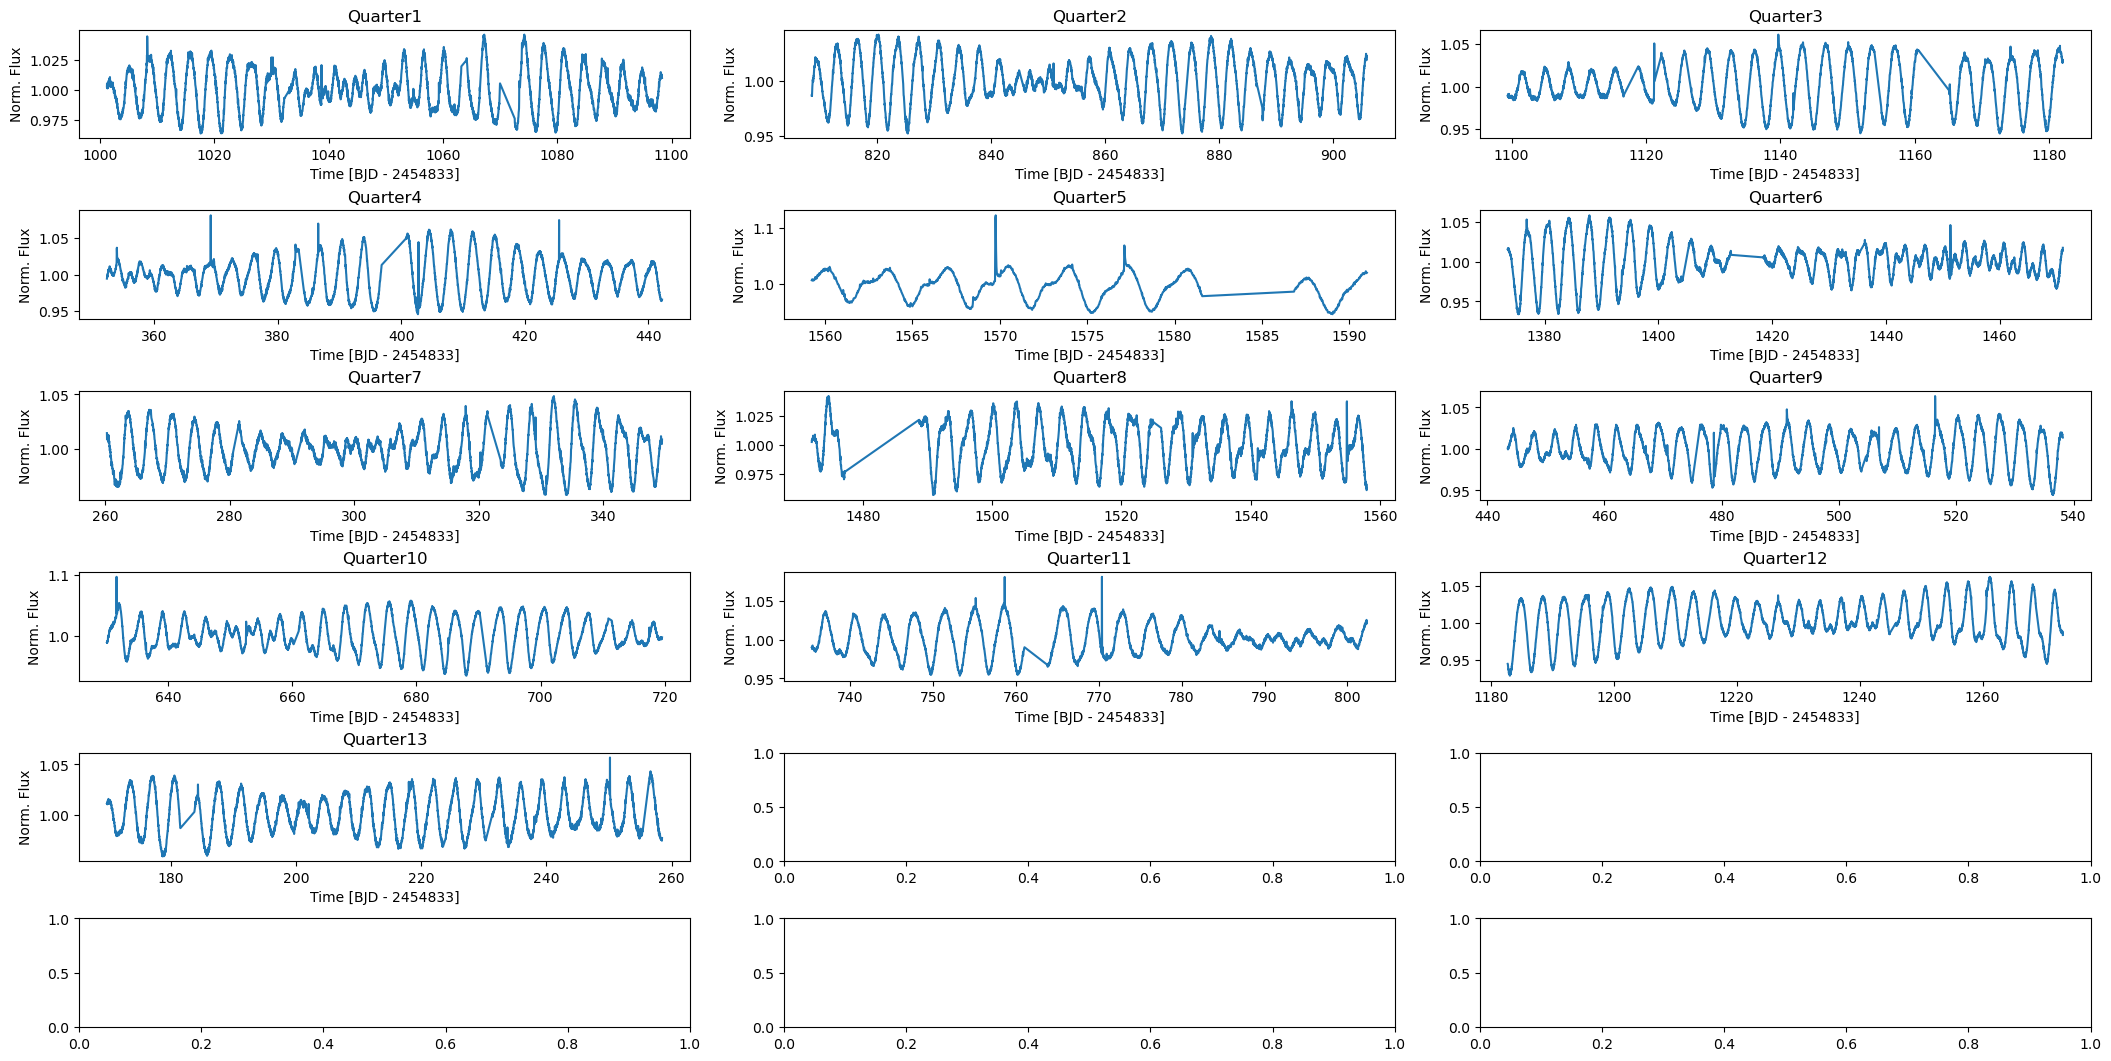

In [60]:
cols = 6
rows = math.ceil(len(light_curves) / cols)

# Create figure
fig, axes = plt.subplots(cols, rows, figsize=(3.5 * cols, 3.5 * rows), layout="constrained")
axes = axes.flatten()  # flatten grid to simple list

# Loop over files and axes
for i,(lc, ax) in enumerate(zip(light_curves, axes)):
    # Normalize
    flux = lc.flux.value / np.nanmedian(lc.flux.value)
    time = lc.time.value
    # Plot each quarter
    print(len(flux))
    ax.plot(time, flux) # shows quarter start time
    ax.set_title("Quarter" + str(i+1))
    ax.set_xlabel("Time [BJD - 2454833]")
    ax.set_ylabel("Norm. Flux")
    
plt.show()

Number of points: 4473


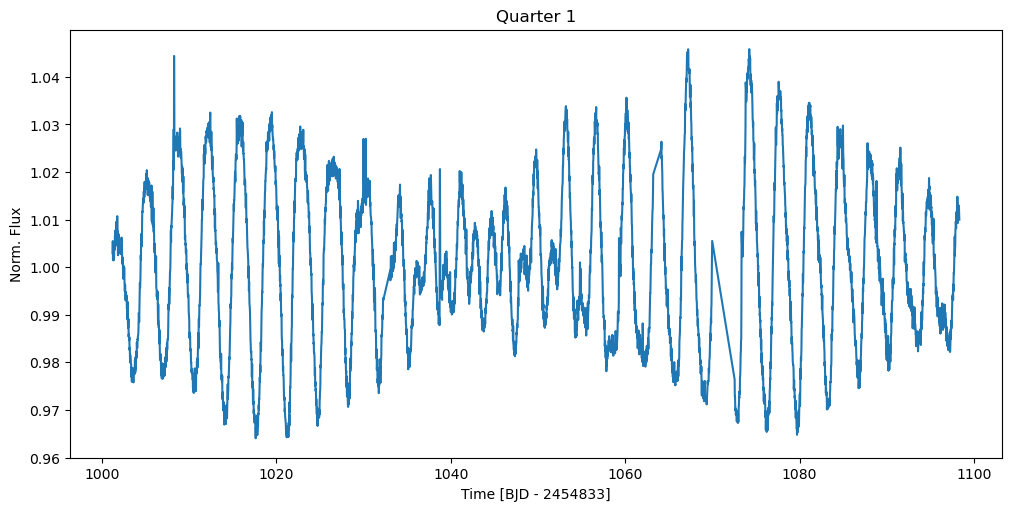

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), layout="constrained")

# Just plot the first light curve
lc = light_curves[0]

# Normalize
flux = lc.flux.value / np.nanmedian(lc.flux.value)
time = lc.time.value

print(f"Number of points: {len(flux)}")

# Plot this quarter
ax.plot(time, flux)
ax.set_title("Quarter 1")
ax.set_xlabel("Time [BJD - 2454833]")
ax.set_ylabel("Norm. Flux")

plt.show()

In [62]:
def process_light_curves(light_curves, algorithm):
    best_periods = []
    for (i, lc) in enumerate(light_curves):
        time = lc.time.value
        flux = lc.flux.value
        mask = np.isfinite(time) & np.isfinite(flux)
        time = np.asarray(time[mask])
        flux = np.asarray(flux[mask])
        flux = (flux / np.nanmedian(flux)) - 1
    
        # Instantiate model
        match(algorithm):
            case "general":
               model = LombScargle()
            case "fast":
                model = LombScargleFast()
            case "trended":
                model =  TrendedLombScargle()
        model.fit(time,flux)
        # Define period/frequency grid
        periods = np.linspace(0.1, 100, 10000)  # days
        power = model.score(periods)
        
        # Find best period
        best_period = periods[np.argmax(power)]
        best_periods.append(best_period)

        if i == 0:
            # Plot periodogram
            plt.figure(figsize=(8,4))
            plt.plot(periods, power)
            plt.xlabel("Period [days]")
            plt.ylabel("Lomb–Scargle Power")
            plt.title("Lomb–Scargle Periodogram " + algorithm)
            plt.xscale("log")
            plt.show()
            print("best period is " + str(best_period) + " days")
    return best_periods

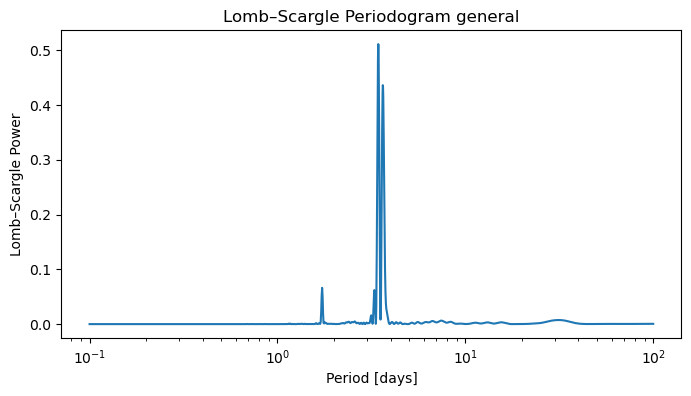

best period is 3.4369936993699373 days


In [63]:
general_best_periods = process_light_curves(light_curves, "general")

In [64]:
print(len(general_best_periods))

13


/opt/homebrew/lib/python3.14/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


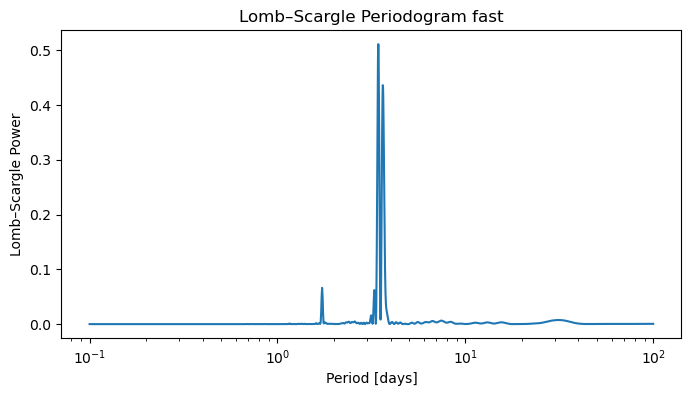

best period is 3.4369936993699373 days


In [65]:
fast_best_periods = process_light_curves(light_curves, "fast")

In [66]:
def print_result(best_periods):
    print("result of lomb scargle period calculation (general) is " +  str(np.mean(best_periods)) + " ± " + str(np.std(best_periods)) + " days") 

In [67]:
print_result(general_best_periods)

result of lomb scargle period calculation (general) is 3.5322924600152326 ± 0.07833815542871943 days


In [68]:
print_result(fast_best_periods)

result of lomb scargle period calculation (general) is 3.5322924600152326 ± 0.07833815542871943 days


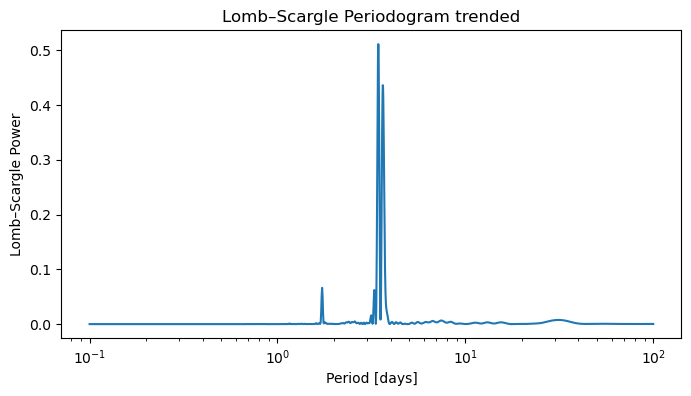

best period is 3.4369936993699373 days


In [37]:
fast_best_periods = process_light_curves(light_curves, "trended")

what is the actual correct answer from paper? Roettenbacher et al. (2013) estimate a rotation period for KIC 5110407 through light-curve inversion of 3.4693 d

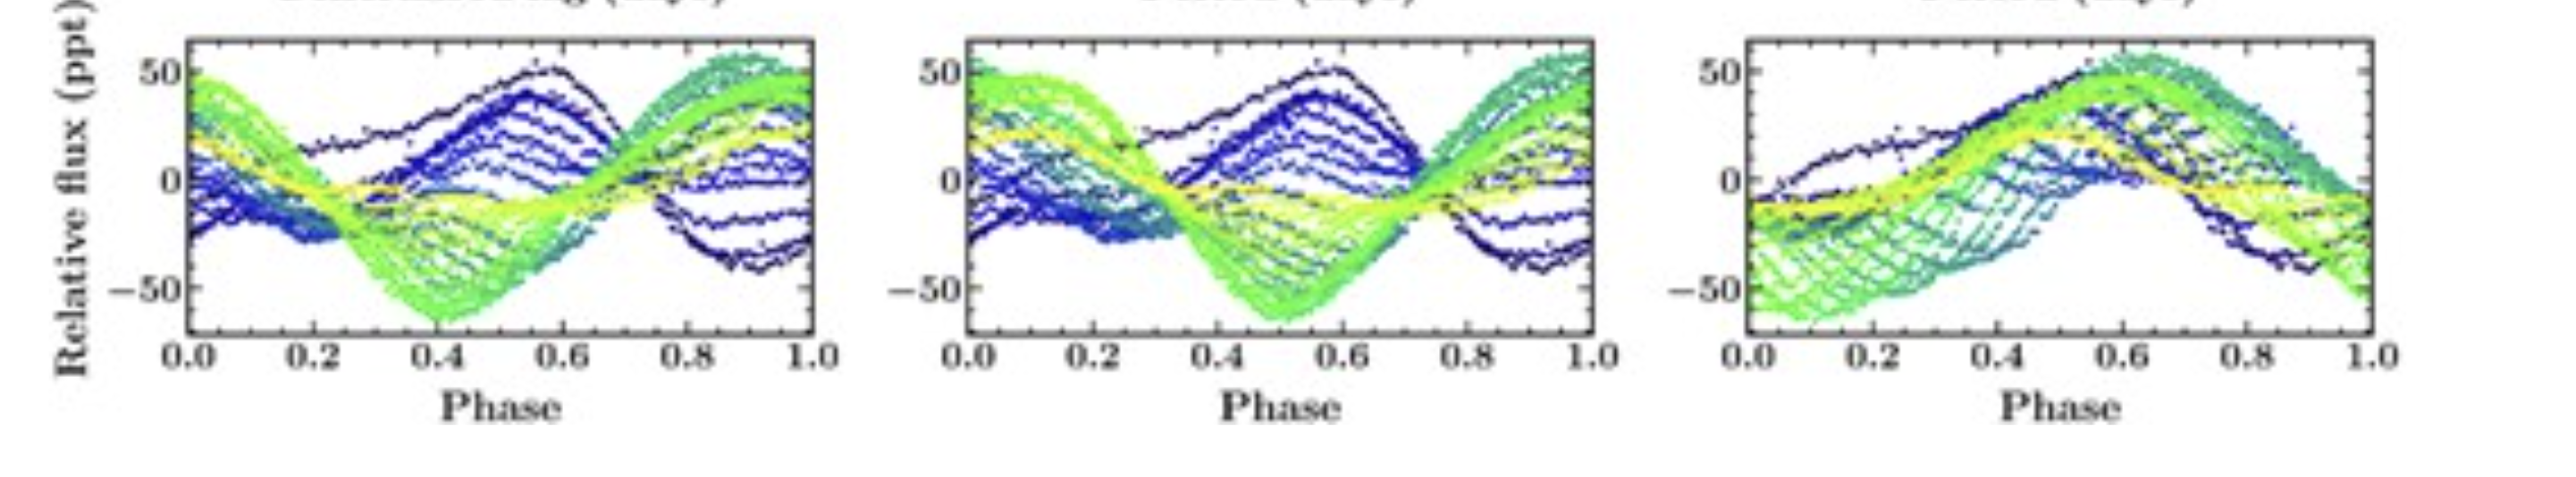 

 isn't LS (right one) the best one here. Even thoughb SACF and GP are similar , they don't seem correct to me?

## Phase Folding Implementation

Now let's implement phase folding to visualize how well our detected periods align the light curves.

In [139]:
def plot_phase_folded(light_curves, period, nbins=50):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    # Get time range for coloring
    all_times = []
    for lc in light_curves:
      all_times.append(np.median(lc.time.value))
    all_times = np.array(all_times)
    time_min, time_max = all_times.min(), all_times.max()
    
    # Color map
    import matplotlib.cm as cm
    cmap = cm.get_cmap('viridis')
    
    # Plot each quarter
    for i, lc in enumerate(light_curves):
      time = lc.time.value
      flux = lc.flux.value
    
      if len(flux) < 10:
          continue
    
      # Normalize to ppt
      flux = (flux / np.nanmedian(flux) - 1)*1e3
    
      # Phase fold
      phase = (time % period) / period
    
      # Sort by phase
      sort_idx = np.argsort(phase)
      phase = phase[sort_idx]
      flux = flux[sort_idx]
    
      phase_bins = np.linspace(0, 1, nbins)
      binned_flux = []
      binned_phases = []
    
      for j in range(len(phase_bins)-1):
          mask = (phase >= phase_bins[j]) & (phase < phase_bins[j+1])
          if np.sum(mask) > 0:
              binned_flux.append(np.median(flux[mask]))
              binned_phases.append((phase_bins[j] + phase_bins[j+1])/2)
    
      if len(binned_phases) == 0:
          continue
    
      # Color by time (blue = early, yellow = late)
      median_time = np.median(time)
      color_val = (median_time - time_min) / (time_max - time_min)
      color = cmap(color_val)
    
      # Plot this quarter
      ax.plot(binned_phases, binned_flux, '-', color=color, linewidth=1.5, alpha=0.8)
    
    ax.set_xlabel('Phase', fontsize=12)
    ax.set_ylabel('Relative Flux (ppt)', fontsize=12)
    ax.set_title(f'All Quarters Phase-Folded (P = {period:.4f} d)', fontsize=14)
    ax.set_xlim(0, 1)
    ax.set_ylim(-100, 100)
    ax.grid(alpha=0.3)
    ax.axhline(0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
    
    plt.tight_layout()
    print("showing")
    plt.show()

showing


/var/folders/jk/y277gdtn4v16jhh80rvcq17s08jmmm/T/ipykernel_48278/2951085637.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


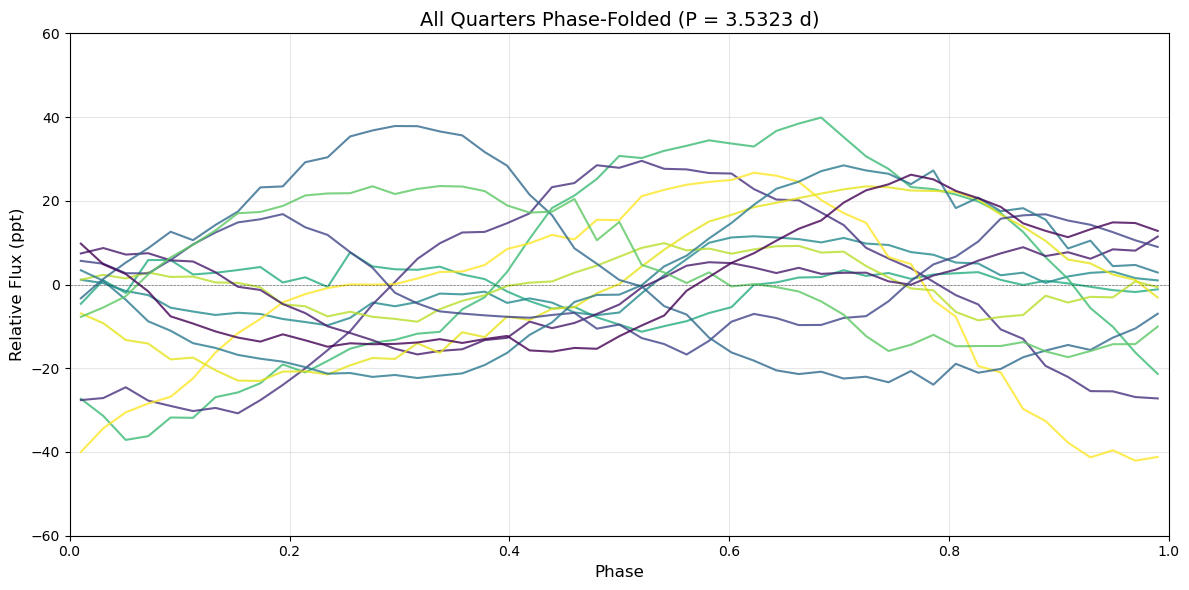

In [109]:
plot_phase_folded(light_curves, np.mean(general_best_periods))

showing


/var/folders/jk/y277gdtn4v16jhh80rvcq17s08jmmm/T/ipykernel_48278/2951085637.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


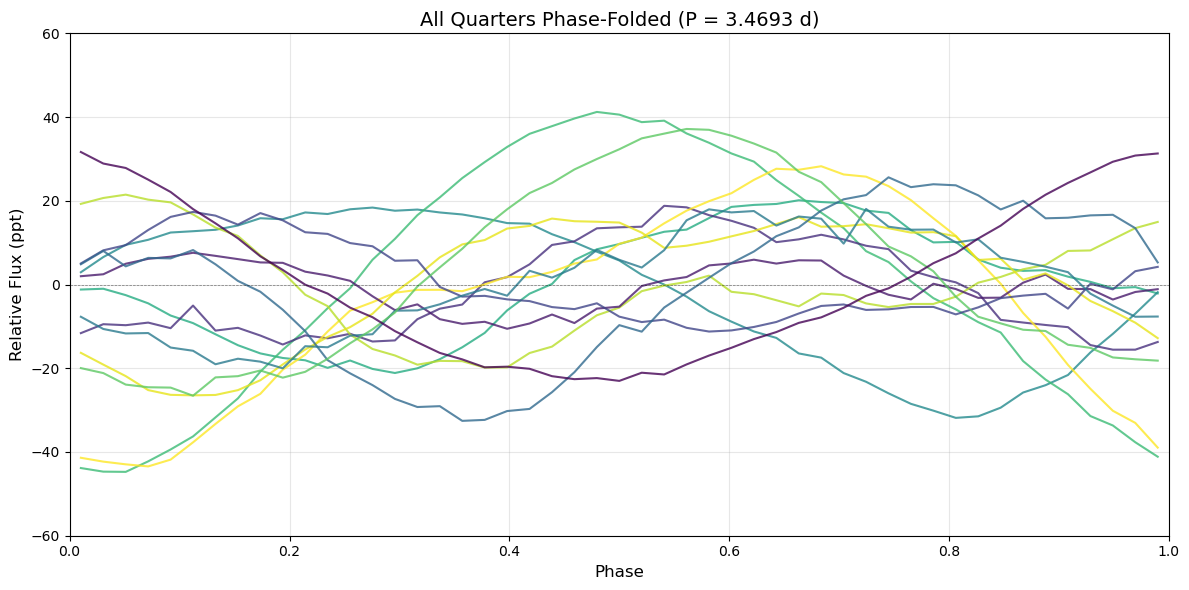

In [110]:
plot_phase_folded(light_curves, 3.4693,50) #this if from the literature value in  Roettenbacher et al. (2013) 

### Comparison of Multiple Periods Side-by-Side

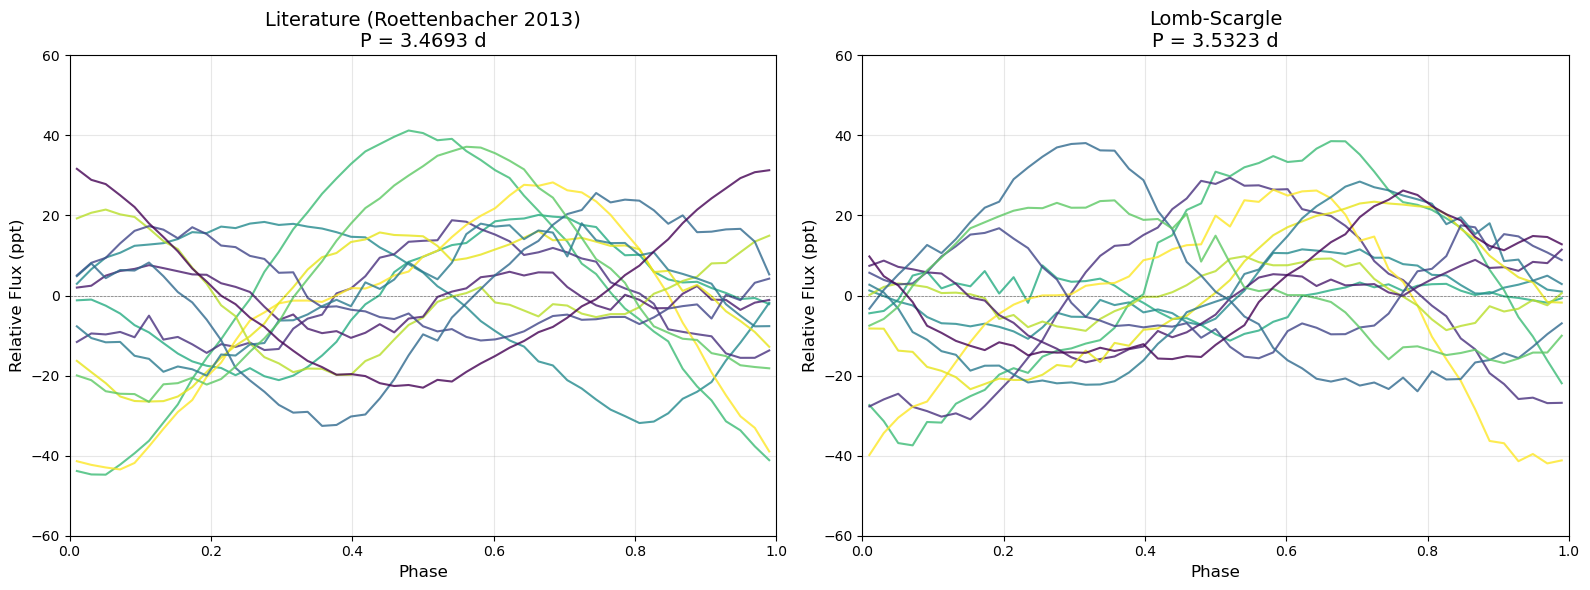

In [114]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

periods = [3.4693, 3.5323]
titles = ['Literature (Roettenbacher 2013)', 'Lomb-Scargle']
nbins = 50

for ax, period, title in zip(axes, periods, titles):
  # Get time range for coloring
  all_times = []
  for lc in light_curves:
      all_times.append(np.median(lc.time.value))
  all_times = np.array(all_times)
  time_min, time_max = all_times.min(), all_times.max()

  import matplotlib.cm as cm
  cmap = plt.colormaps.get_cmap('viridis')

  # Plot each quarter
  for i, lc in enumerate(light_curves):
      time = lc.time.value
      flux = lc.flux.value

      mask = np.isfinite(time) & np.isfinite(flux)
      time = time[mask]
      flux = flux[mask]

      if len(flux) < 10:
          continue

      flux = (flux / np.nanmedian(flux) - 1) * 1e3
      phase = (time % period) / period

      sort_idx = np.argsort(phase)
      phase = phase[sort_idx]
      flux = flux[sort_idx]

      phase_bins = np.linspace(0, 1, nbins)
      binned_flux = []
      binned_phases = []

      for j in range(len(phase_bins)-1):
          mask_bin = (phase >= phase_bins[j]) & (phase < phase_bins[j+1])
          if np.sum(mask_bin) > 0:
              binned_flux.append(np.median(flux[mask_bin]))
              binned_phases.append((phase_bins[j] + phase_bins[j+1])/2)

      if len(binned_phases) == 0:
          continue

      median_time = np.median(time)
      color_val = (median_time - time_min) / (time_max - time_min)
      color = cmap(color_val)

      ax.plot(binned_phases, binned_flux, '-', color=color, linewidth=1.5, alpha=0.8)

  ax.set_xlabel('Phase', fontsize=12)
  ax.set_ylabel('Relative Flux (ppt)', fontsize=12)
  ax.set_title(f'{title}\nP = {period:.4f} d', fontsize=14)
  ax.set_xlim(0, 1)
  ax.set_ylim(-60, 60)
  ax.grid(alpha=0.3)
  ax.axhline(0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.show()

## Ground-Based Observation Simulation

Now let's simulate how this data would look if observed from the ground instead of space. Following the paper's methodology:
- **Night-time only**: 8 hours of observation per 24-hour period
- **Bad weather gaps**: Specific periods are masked to simulate cloudy nights
  - 18.5–22.5 days
  - 34.5–37.5 days
  - 48.5–52.5 days
  - 62.5–64.5 days
  - 76.5–81.5 days
  
This will drastically reduce the number of data points and create gaps in coverage.

In [118]:
def simulate_ground_observation_paper(lc):
    """
    Simulate ground-based observations following the paper's method:
    - Night-time: 8h of each 24h period
    - Bad weather at specific times: 18.5–22.5, 34.5–37.5, 48.5–52.5, 62.5–64.5, 76.5–81.5 d
    
    Parameters:
    -----------
    lc : light curve object
        Single Kepler light curve
    
    Returns:
    --------
    time_ground, flux_ground : arrays
        Simulated ground-based time and flux
    """
    time = lc.time.value.copy()
    flux = lc.flux.value.copy()
    
    # Remove NaNs from original
    mask = np.isfinite(time) & np.isfinite(flux)
    time = time[mask]
    flux = flux[mask]
    
    # Get start time of this quarter
    time_start = time.min()
    
    # Convert to relative time (days since start of quarter)
    time_rel = time - time_start
    
    # Create mask for observable data
    observable_mask = np.ones(len(time), dtype=bool)
    
    # 1. Apply night-time only (8h per 24h period)
    # Assume night is the middle 8 hours of each day
    hours_per_day = 24.0
    night_duration = 8.0 / hours_per_day  # 8 hours = 1/3 day
    
    for day in range(int(time_rel.max()) + 1):
        # Night window: centered in each day
        night_start = day + (1 - night_duration) / 2
        night_end = night_start + night_duration
        
        # Mask out daytime (keep only night)
        daytime_mask = (time_rel >= day) & (time_rel < night_start) | \
                       (time_rel >= night_end) & (time_rel < day + 1)
        observable_mask &= ~daytime_mask
    
    # 2. Apply bad weather periods (relative to start of quarter)
    bad_weather_periods = [
        (18.5, 22.5),
        (34.5, 37.5),
        (48.5, 52.5),
        (62.5, 64.5),
        (76.5, 81.5)
    ]
    
    for start, end in bad_weather_periods:
        weather_mask = (time_rel >= start) & (time_rel <= end)
        observable_mask &= ~weather_mask
    
    # Keep only observable points
    time_ground = time[observable_mask]
    flux_ground = flux[observable_mask]
    
    return time_ground, flux_ground

Created 13 ground-based light curves


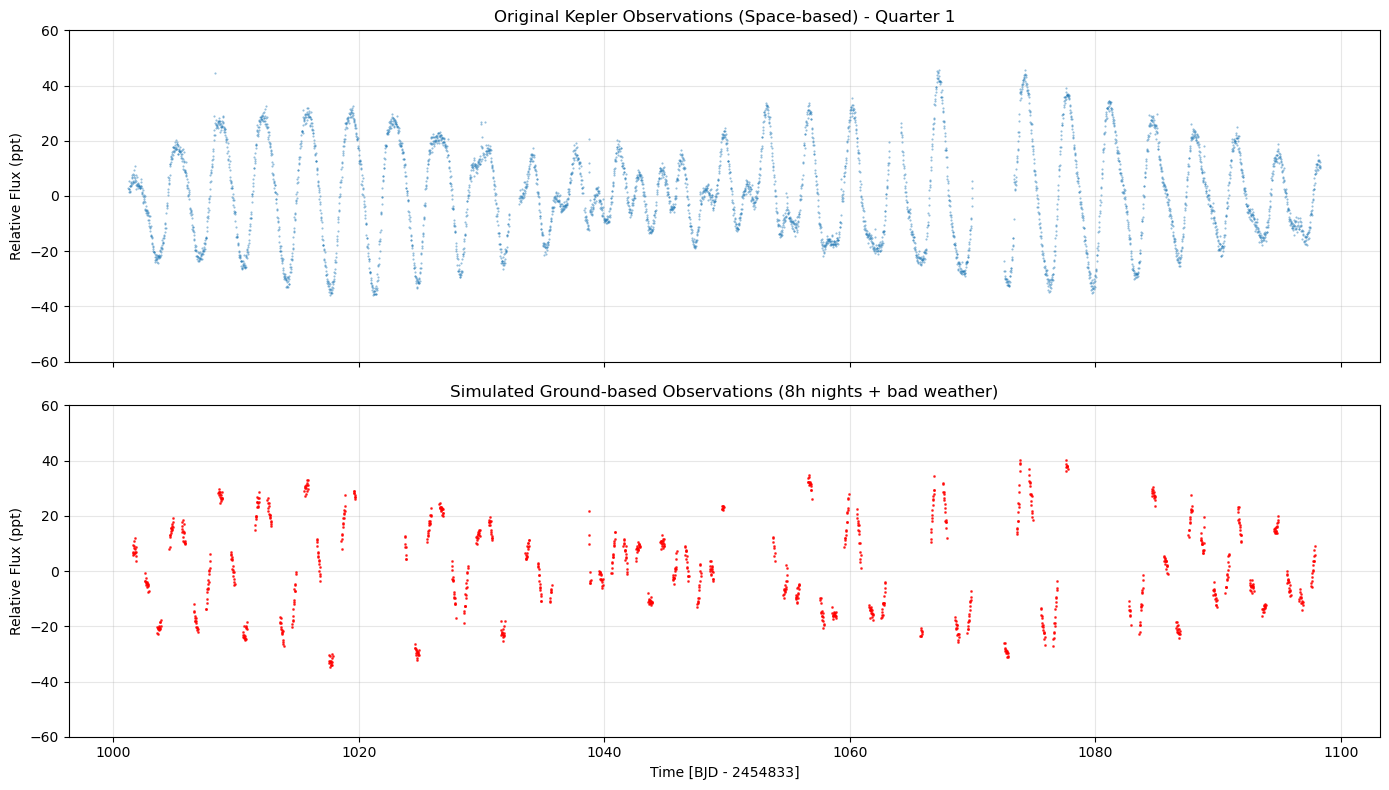


Quarter 1 comparison:
Original Kepler points: 4473
Ground-based points: 1224
Data retention: 27.4%


In [133]:
# Simulate ground-based observations for ALL quarters
ground_light_curves = []

for lc in light_curves:
    time_ground, flux_ground = simulate_ground_observation_paper(lc)
    
    # Create a simple object to store the data (similar to light curve structure)
    class GroundLC:
        def __init__(self, time, flux):
            self.time = type('obj', (object,), {'value': time})()
            self.flux = type('obj', (object,), {'value': flux})()
    
    ground_light_curves.append(GroundLC(time_ground, flux_ground))

print(f"Created {len(ground_light_curves)} ground-based light curves")

# Plot comparison for first quarter
lc = light_curves[0]
lc_ground = ground_light_curves[0]

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Original Kepler data
time = lc.time.value
flux = lc.flux.value
mask = np.isfinite(time) & np.isfinite(flux)
time = time[mask]
flux_norm = (flux[mask] / np.nanmedian(flux[mask]) - 1) * 1e3

axes[0].plot(time, flux_norm, '.', markersize=1, alpha=0.5)
axes[0].set_ylabel('Relative Flux (ppt)')
axes[0].set_title('Original Kepler Observations (Space-based) - Quarter 1')
axes[0].grid(alpha=0.3)
axes[0].set_ylim(-60, 60)

# Ground-based simulation
time_ground = lc_ground.time.value
flux_ground = lc_ground.flux.value
flux_ground_norm = (flux_ground / np.nanmedian(flux_ground) - 1) * 1e3

axes[1].plot(time_ground, flux_ground_norm, '.', markersize=2, alpha=0.7, color='red')
axes[1].set_xlabel('Time [BJD - 2454833]')
axes[1].set_ylabel('Relative Flux (ppt)')
axes[1].set_title('Simulated Ground-based Observations (8h nights + bad weather)')
axes[1].grid(alpha=0.3)
axes[1].set_ylim(-60, 60)

plt.tight_layout()
plt.show()

print(f"\nQuarter 1 comparison:")
print(f"Original Kepler points: {len(time)}")
print(f"Ground-based points: {len(time_ground)}")
print(f"Data retention: {len(time_ground)/len(time)*100:.1f}%")

In [135]:
print(len(ground_light_curves))

13


## Time period estimation for the ground based observations

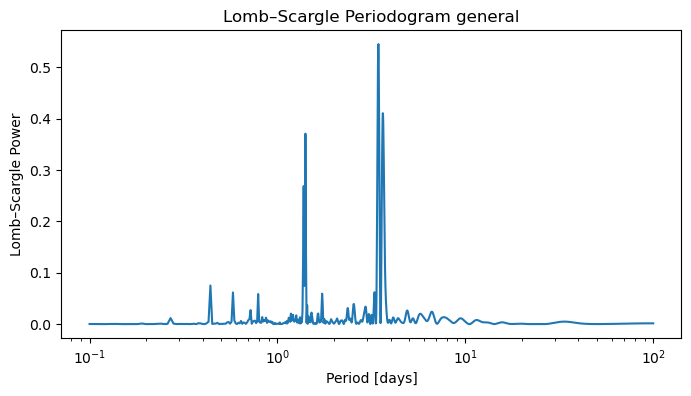

best period is 3.4469846984698473 days


In [136]:
ground_based_time_periods = process_light_curves(ground_light_curves ,"general")

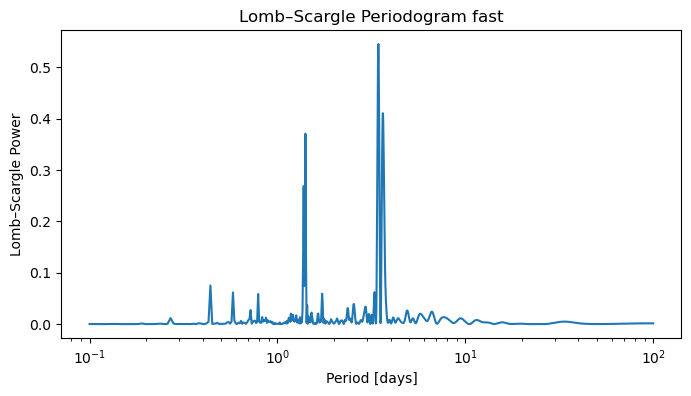

best period is 3.4469846984698473 days


In [129]:
ground_based_time_periods_fast = process_light_curves(ground_light_curves ,"fast")

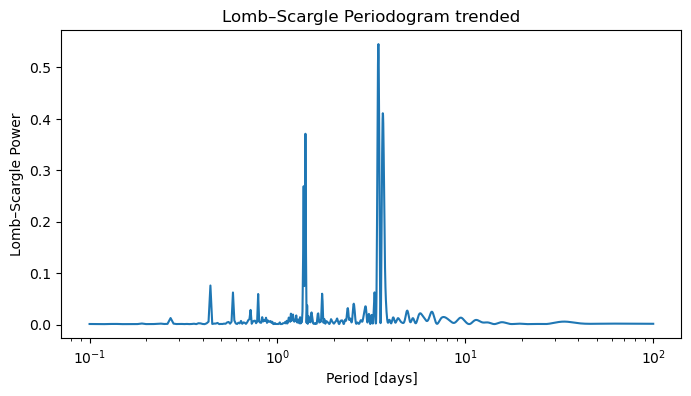

best period is 3.4469846984698473 days


In [146]:
ground_based_time_periods_trended = process_light_curves(ground_light_curves ,"trended")

In [137]:
np.mean(ground_based_time_periods)

np.float64(3.532292460015232)

In [144]:
np.mean(ground_based_time_periods_fast)

np.float64(3.4469846984698473)

In [145]:
np.mean(ground_based_time_periods_trended)

np.float64(3.4469846984698473)

showing


/var/folders/jk/y277gdtn4v16jhh80rvcq17s08jmmm/T/ipykernel_48278/4267963227.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


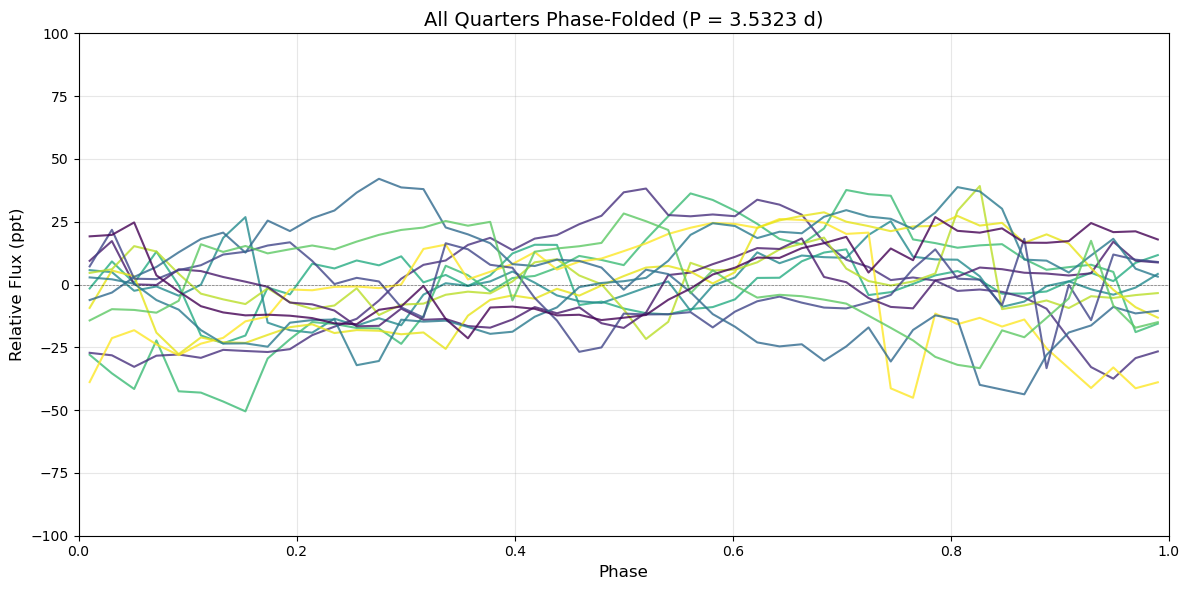

In [147]:
plot_phase_folded(ground_light_curves, np.mean(ground_based_time_periods))

showing


/var/folders/jk/y277gdtn4v16jhh80rvcq17s08jmmm/T/ipykernel_48278/4267963227.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


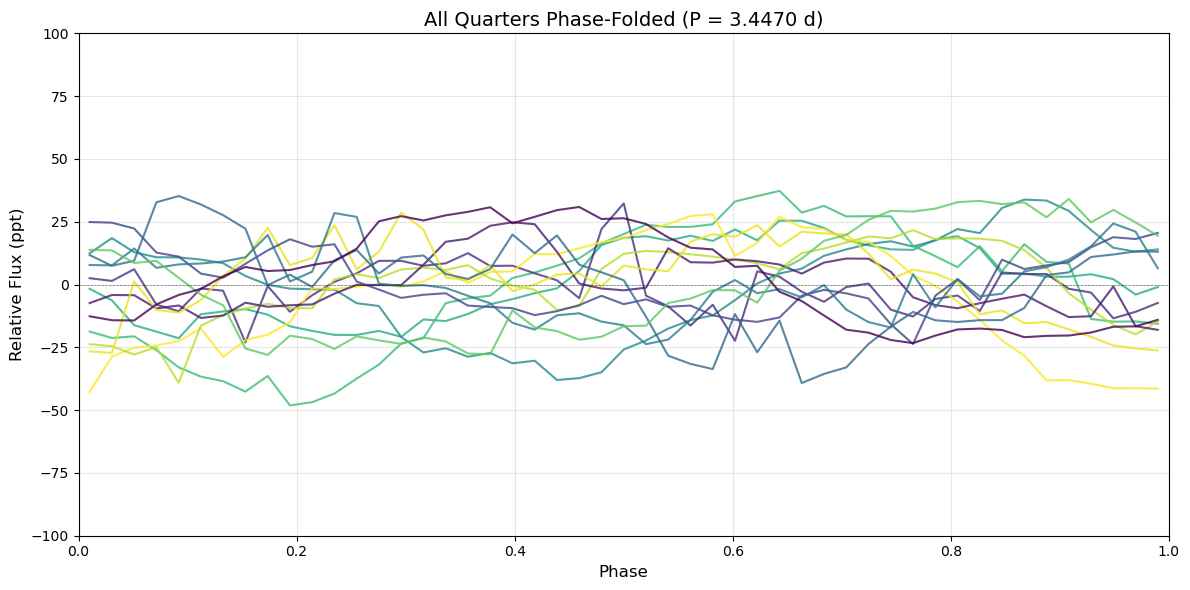

In [148]:
plot_phase_folded(ground_light_curves, np.mean(ground_based_time_periods_fast))

showing


/var/folders/jk/y277gdtn4v16jhh80rvcq17s08jmmm/T/ipykernel_48278/4267963227.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


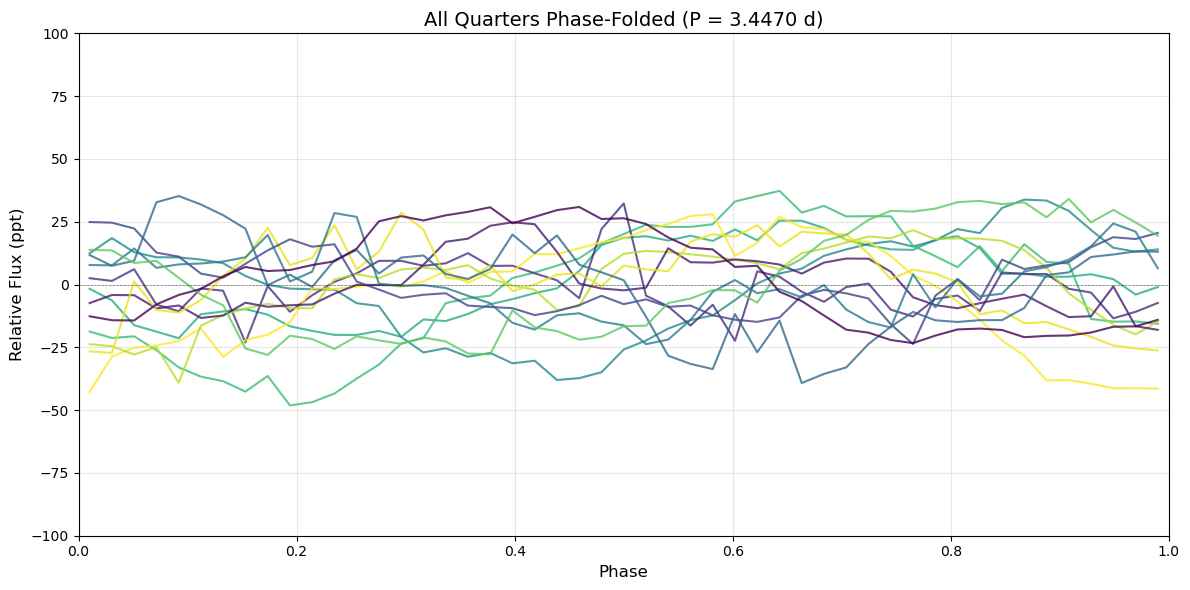

In [143]:
plot_phase_folded(ground_light_curves, np.mean(ground_based_time_periods_trended))

showing


/var/folders/jk/y277gdtn4v16jhh80rvcq17s08jmmm/T/ipykernel_48278/4267963227.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


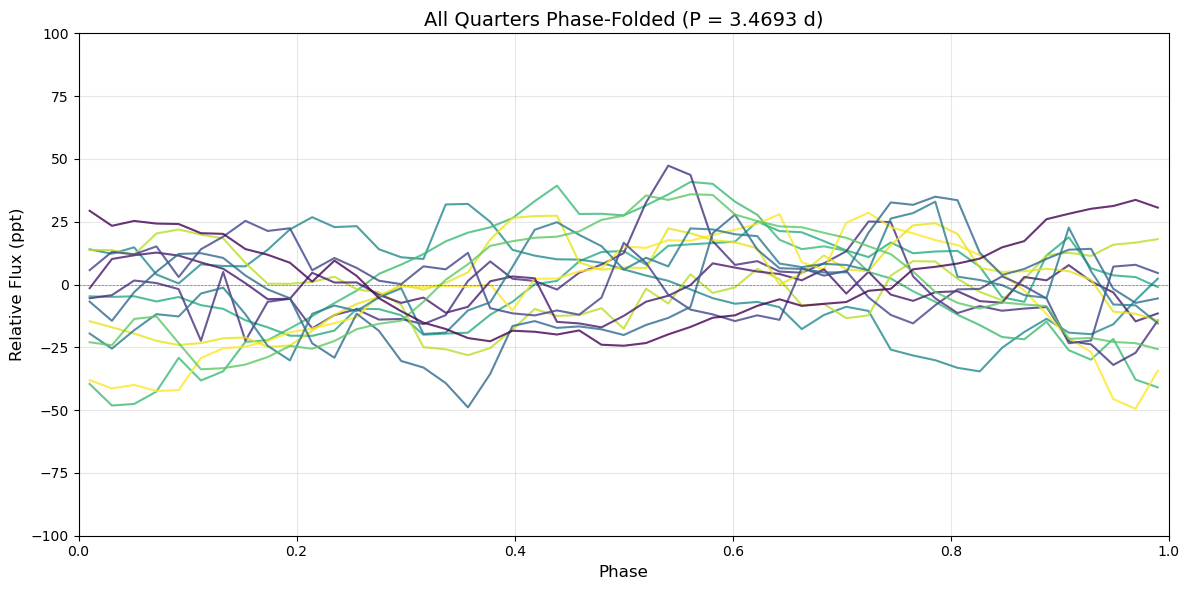

In [149]:
plot_phase_folded(ground_light_curves,3.4693)